<a href="https://colab.research.google.com/github/hrutkabence/tutorials/blob/master/hungarian/python/pylint_hu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hogyan írjunk szép Python kódot?

A Python készítésére többféle stílus létezik. Hány szóközzel húzzuk be a kódblokkokat, hogyan nevezzük el a változókat, függvényeket, osztályokat?
Elhelyeztük-e a megfelelő megjegyzés sorokat, ...

A feltiek ellenőrzésére többféle automatizált megoldás létezik (például pylint, pyChecker, Pylint)

Ebben a dokumentumban röviden bemutatjuk a Pylint használatát.

A *pylint* parancssori eszközt külön kell telepíteni, nem része a Python telepítőnek.

A következő sor telepíteni fogja a *pylint* segédprogramot a Colab virtuális gépen. A saját gépén is telepítenie kell, de a sor elejéről hagyja el a felkiáltójelet.

---
**Megjegyzés**

>Ez csak egy rövid ismertető a *pylint* használatához. További információt a  [Pylint felhasználói kézikönyv](https://pylint.pycqa.org/en/latest/)ében talál.
---

In [1]:
!python -m pip install pylint -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.6/510.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.2/275.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00


Ellenőrizzük, hogy sikeres volt-e telepítés.

In [2]:
!pylint --version

pylint 3.0.3
astroid 3.0.2
Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


Mint sok már parancssori program a *pylint* visszaírja a rövid felhasználói útmutatót, ha paraméterek nélkül vagy a -h kapcsolóval indítjuk el.


Töltsünk le egy minta programot és adat fájlt.

In [3]:
!wget -q -O sample_data/lidar.txt https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/data_processing/lessons/code/lidar.txt
!wget -q -O vslide1.py https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/data_processing/lessons/code/vslide1.py

A program forráskódját bemásoltuk a következő kódblokkba. A program egy metszetet rajzol ki egy pontfelhő pontjait tartalmazó szövegfájl pontjaiból.

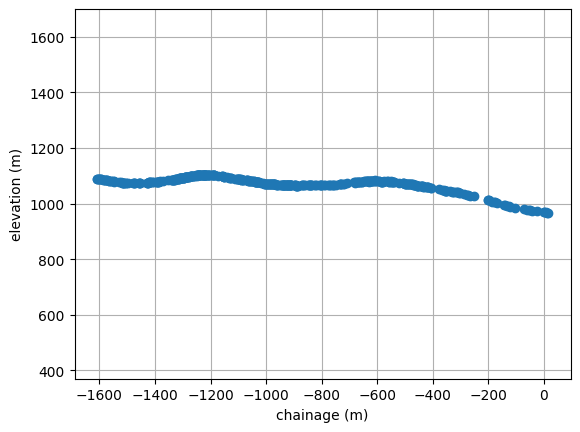

In [4]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import sys
from math import hypot
import numpy as np
from matplotlib import pyplot as plt

def vplain(x1, y1, x2, y2):
    """ set up line equation
    vp[0] * x + vp[1] * y + vp[2] = 0

    x1, y1 - horizontal coordinates of the start point of the section
    x2, y2 - horizontal coordinates of the end point of the section
    returns a numpy array with coefficients of the vertical plane
    """

    vp = np.zeros((3,))
    vp[0] = y1 - y2
    vp[1] = x2 - x1
    vp[2] = x1 * y2 - x2 * y1
    vp = vp / hypot(vp[0], vp[1]) # normalize
    return vp

def section(pc, x1, y1, x2, y2, tol):
    """ Select point from a point cloud near to a line

    pc - point cloud in a numpy array
    x1, y1 - horizontal coordinates of the start point of the section
    x2, y2 - horizontal coordinates of the end point of the section
    tol - tolerance distance from the section
    returns a numpy array with points near to the section
    """
    pc1 = pc.copy()
    pc1[:, 2] = 1 # change to homogenous coordinates
    vp = vplain(x1, y1, x2, y2) # equation of vertical plain
    sec = pc[np.abs(np.dot(pc1, vp)) < tol] # select points close to the section

    return sec

def tr(e1, n1, e2, n2):
    """ set up transformation matrix for homogenous coordinates

    Parameters:
    e1, n1 - start point of the section line
    e2, n2 - end point of the section section line
    returns the transformation matrix
    """
    de = e2 - e1
    dn = n2 - n1

    d = hypot(de, dn) # distance
    r = de / d # sin
    m = dn / d # cos
    return np.dot(np.array([[1, 0, 0], [0, 1, 0], [-e1, -n1, 1]]),
                np.array([[m, r, 0], [-r, m, 0], [0, 0, 1]]))

if len(sys.argv) < 7:
    pc = np.loadtxt('sample_data/lidar.txt', delimiter=',') ;# load point cloud
    x1 = 548060.0
    y1 = 5129130.0
    x2 = 255130.0
    y2 = 5129030.0
    tol = 1.0
else:
    pc = np.loadtxt(sys.argv[1], delimiter=',') ;# load point cloud
    x1 = float(sys.argv[2])
    y1 = float(sys.argv[3])
    x2 = float(sys.argv[4])
    y2 = float(sys.argv[5])
    tol = float(sys.argv[6])
# set up equation for vertical plain a * x + b * y + c = 0
vp = vplain(x1, y1, x2, y2)
mind=1e38
sec = section(pc,x1,y1,x2,y2,tol)
# transformation matrix
trm = tr(x1, y1, x2, y2)
# make a copy of section points for homogenous transformation
pc1 = sec.copy()
pc1[:, 2] = 1
pc1 = np.dot(pc1, trm) # rotate points into the section plain
pc1[:, 2] = sec[:, 2] # copy back elevations to transformed points

plt.plot(pc1[:,1], pc1[:,2], 'o')
plt.xlabel('chainage (m)')
plt.ylabel('elevation (m)')
plt.axis('equal')
plt.grid('on')
plt.show()

Amint a fenti ábrából is láthatjuk, a programunk működik. De jól dokunentált és megfelel az általános programozói szabályokat? Ellenőrizzük a *pylint* futtatásával.

In [5]:
!pylint vslide1.py

************* Module vslide1
vslide1.py:60:0: W0311: Bad indentation. Found 6 spaces, expected 8 (bad-indentation)
vslide1.py:60:0: W0301: Unnecessary semicolon (unnecessary-semicolon)
vslide1.py:61:0: W0311: Bad indentation. Found 6 spaces, expected 8 (bad-indentation)
vslide1.py:62:0: W0311: Bad indentation. Found 6 spaces, expected 8 (bad-indentation)
vslide1.py:63:0: W0311: Bad indentation. Found 6 spaces, expected 8 (bad-indentation)
vslide1.py:64:0: W0311: Bad indentation. Found 6 spaces, expected 8 (bad-indentation)
vslide1.py:69:0: W0311: Bad indentation. Found 6 spaces, expected 8 (bad-indentation)
vslide1.py:71:0: W0301: Unnecessary semicolon (unnecessary-semicolon)
vslide1.py:79:37: C0303: Trailing whitespace (trailing-whitespace)
vslide1.py:96:14: C0303: Trailing whitespace (trailing-whitespace)
vslide1.py:1:0: C0114: Missing module docstring (missing-module-docstring)
vslide1.py:9:11: W0621: Redefining name 'x1' from outer scope (line 61) (redefined-outer-name)
vslide1.py:

A hosszú listából konstatálhatjuk, hogy bár a kódunk hibátlanul működik, sok javítanivaló van benne. A hibajelzések száma előtti betű jelzi a hiba jellegét.
Az F (fatal) és E (error) betűkkel kezdődő üzenetek olyan hibát jeleznek, mely a programunk futtatását is gátolják. A W (warning), C (convetion) és R (refactor) betűvel kezdődőek figyelmeztetések, melyeket célszerű javítani.

A lista végén egy tíz pontig terjedő skálán pontozza a kódunkat a *pylint*. Az "ügyesek" negatív pontot is kaphatnak. A kapott 3.77 nem túl sok.

Nyissa meg a python kódot tartalmazó fájl a Colab fájl böngészőjében duplán a fájl nevére kattintva és javítsa a jelzett hibákat a kódban. Ezután mentse el a fájlt és futtassa újra az előző kódblokban szereplő ellenőrzést.

#Feladat

- A *pylint* használatával érjen el legalább 5 pontot az értékelésben.
- Vizsgálja meg a saját Python programjait és javítsa a felmerülő problémákat!